# Imports

In [1]:
from dataclasses import dataclass
from pathlib import Path
import pandas as pd
from datetime import datetime
import numpy as np
import random
import seaborn as sns
from tqdm.contrib.concurrent import thread_map
from typing import Optional, Tuple, Union
import matplotlib.pyplot as plt
from anonymeter.evaluators import SinglingOutEvaluator
from collections import Counter
import re
from upsetplot import from_memberships, UpSet
from matplotlib.ticker import NullLocator
import warnings


# User Configurations

In [2]:
@dataclass
class Config:
    data_dir: Path = Path("../../data")
    figures_dir: Path = Path("figures")
    results_dir: Path = Path("results")

    real_file: str = "20250301_data_20250510_122405_final_100_train.csv"
    synth_file: str = "20250301_data_20250510_122405_final_100_synth.csv"
    holdout_file: str = "20250301_data_20250510_122405_final_100_holdout.csv"

    random_seed: int = 42
    sampling_size: int = None # None if no sampling

    save_data: bool = True

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)


# Utility Functions

In [3]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        # df[col] = df[col].astype('category')
        df[col] = df[col].astype('object') # 'category' führt zu Problemen mit dem OneHotEncoder

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')
        # df[col] = df[col].astype('int32')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = None,
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

# Main Routine
## Data Import

In [4]:
cfg = Config()
current_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

df_train, df_synth, df_holdout = load_data(
    cfg.real_file,
    cfg.synth_file,
    cfg.holdout_file,
    data_dir=cfg.data_dir
)

In [5]:
target_col = 'icu_admission_24h'
num_cols = ['age', 'temperature', 'heart_rate', 'respiratory_rate', 'oxygen_saturation', 'systolic_bp', 'diastolic_bp']
cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block', 'night_arrival', 'weekend_arrival']
ord_cols = ['consciousness_level','news_score']
bool_cols = ['night_arrival', 'weekend_arrival']

## Sampling

In [6]:
if cfg.sampling_size is not None: # stratify bzw. weights führt zu Fehler: ausschließlich True
    df_train = df_train.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)
    df_synth = df_synth.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)
    df_holdout = df_holdout.sample(n=cfg.sampling_size, replace=True, random_state=cfg.random_seed).reset_index(drop=True)

## Attack Parameters
### Parameter

In [7]:
n_attacks = 2500
n_jobs = 12
n_cols = 3
attacks_per_job = n_attacks // n_jobs
max_attempts_per_job = attacks_per_job * 1000

Debug-Parameter

In [8]:
# n_attacks = 1000
# n_jobs = 12
# n_cols = 5
# attacks_per_job = n_attacks // n_jobs
# max_attempts_per_job = attacks_per_job * 1000

## Train vs. Synthetic

In [9]:
def partial_train_vs_synth(seed):
    random.seed(seed)
    np.random.seed(seed)

    evaluator = SinglingOutEvaluator(
        ori=df_train,
        syn=df_synth,
        n_attacks=attacks_per_job,
        n_cols=n_cols,
        max_attempts=max_attempts_per_job
    )
    pr = evaluator.evaluate().risk()
    queries = evaluator.queries()  # erfolgreiche singling-out-queries
    return {
        "value": pr.value,
        "ci_lower": pr.ci[0],
        "ci_upper": pr.ci[1],
        "queries": queries
    }

In [ ]:
# 45 Min.
seeds = list(range(n_jobs))
results_train_synthetic = thread_map(partial_train_vs_synth, seeds, max_workers=n_jobs)

# Extract queries from each parallel run and flatten into one list
queries_runs = [r["queries"] for r in results_train_synthetic]
all_queries_train_synthetic = [q for run in queries_runs for q in run]

# Aggregation der Ergebnisse
values    = [r["value"]    for r in results_train_synthetic]
ci_lowers = [r["ci_lower"] for r in results_train_synthetic]
ci_uppers = [r["ci_upper"] for r in results_train_synthetic]

mean_value_train_synthetic   = np.mean(values)
mean_ci_low_train_synthetic  = np.mean(ci_lowers)
mean_ci_high_train_synthetic = np.mean(ci_uppers)

  0%|          | 0/12 [00:00<?, ?it/s]

In [11]:
print(f"Train vs. Synthetic: Risk = {mean_value_train_synthetic:.4f} (95% CI: {mean_ci_low_train_synthetic:.4f} – {mean_ci_high_train_synthetic:.4f})")

Train vs. Synthetic: Risk = 0.1338 (95% CI: 0.0884 – 0.1791)


In [12]:
all_queries = [q for res in results_train_synthetic for q in res["queries"]]

In [13]:
_op_pattern = re.compile(r'([A-Za-z_]\w*)\s*(?:==|<=|>=|<|>)')

def count_features(conditions):
    cnt = Counter()
    for cond in conditions:
        feats = [ft.strip() for ft in cond.split('&')]
        names = []
        for ft in feats:
            names += _op_pattern.findall(ft)
        key = tuple(sorted(names))
        cnt[key] += 1
    return cnt

def counts_to_df(cnt):
    data = [
        {'feature': ' + '.join(key), 'count': count}
        for key, count in cnt.items()
    ]
    df = pd.DataFrame(data)
    return df.sort_values(by=['count', 'feature'], ascending=[False, True]).reset_index(drop=True)

In [14]:
# Features zählen und DataFrame erstellen
feature_counts = count_features(all_queries)
df_features = counts_to_df(feature_counts)

# # Ergebnis anzeigen
# print(df_features.head(20))

## Holdout vs. Synthetic

In [15]:
def partial_train_vs_synth(seed):
    random.seed(seed)
    np.random.seed(seed)

    evaluator = SinglingOutEvaluator(
        ori=df_holdout,
        syn=df_synth,
        n_attacks=attacks_per_job,
        n_cols=n_cols,
        max_attempts=max_attempts_per_job
    )
    pr = evaluator.evaluate().risk()
    queries = evaluator.queries()  # erfolgreiche singling-out-queries
    return {
        "value": pr.value,
        "ci_lower": pr.ci[0],
        "ci_upper": pr.ci[1],
        "queries": queries
    }

In [ ]:
# 30 Min.
seeds = list(range(n_jobs))
results_holdout_synthetic = thread_map(partial_train_vs_synth, seeds, max_workers=n_jobs)

# Extract queries from each parallel run and flatten into one list
queries_runs = [r["queries"] for r in results_holdout_synthetic]
all_queries_holdout_synthetic = [q for run in queries_runs for q in run]

# Aggregation der Ergebnisse
values    = [r["value"]    for r in results_holdout_synthetic]
ci_lowers = [r["ci_lower"] for r in results_holdout_synthetic]
ci_uppers = [r["ci_upper"] for r in results_holdout_synthetic]

mean_value_holdout_synthetic   = np.mean(values)
mean_ci_low_holdout_synthetic  = np.mean(ci_lowers)
mean_ci_high_holdout_synthetic = np.mean(ci_uppers)

  0%|          | 0/12 [00:00<?, ?it/s]

In [17]:
print(f"Holdout vs. Synthetic: Risk = {mean_value_holdout_synthetic:.4f} (95% CI: {mean_ci_low_holdout_synthetic:.4f} – {mean_ci_high_holdout_synthetic:.4f})")

Holdout vs. Synthetic: Risk = 0.1078 (95% CI: 0.0668 – 0.1488)


In [18]:
all_queries_holdout_synthetic = [q for res in results_holdout_synthetic for q in res["queries"]]

In [19]:
# Features zählen und DataFrame erstellen
feature_counts_holdout_synthetic = count_features(all_queries_holdout_synthetic)
df_features_holdout_synthetic = counts_to_df(feature_counts_holdout_synthetic)

# # Ergebnis anzeigen
# print(df_features_holdout_synthetic.head(20))

# Visualisierung

### Visual Utility Functions

In [37]:
def plot_point_estimate_ci(df_plot, figsize=(1.1, 2.1), point_size=6, x_margin=0.4, title="Point estimate with 95% CI"):
    plt.figure(figsize=figsize)
    sns.pointplot(
        data=df_plot,
        x="dataset",
        y="value",
        errorbar=None,
        linestyle='none',
        markersize=point_size,
        color="black",
    )
    plt.errorbar(
        x=range(len(df_plot)),
        y=df_plot["value"],
        yerr=[df_plot["ci_lower_err"], df_plot["ci_upper_err"]],
        fmt='o',
        ecolor='black',
        capsize=5
    )
    plt.ylim(0, max(df_plot["ci_high"])*1.1)
    plt.ylabel("Singling-out risk")
    plt.title(title)
    plt.xlabel("")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(
        ticks=range(len(df_plot)),
        labels=["Train vs. Synth", "Hout vs. Synth"],
        rotation=35,
        ha='right',
    )
    plt.margins(x=x_margin)
    if cfg.save_data:
        fname = f'Singling-Out_Risks_{current_timestamp}.tiff'
        fullpath = cfg.figures_dir / f'{fname}'
        plt.savefig(
            fullpath,
            dpi=300,
            format='tiff',
            bbox_inches='tight',
            pil_kwargs={'compression': 'tiff_lzw'}
        )
        print(f"Abbildung gespeichert unter: {fullpath}")
    plt.show()

In [187]:
def plot_feature_combinations_upset(df_features, show_n_bars=15, title=None, figsize=(7.2, 5.4)):
    """
    Plots an UpSet chart of feature combinations.

    Parameters
    ----------
    df_features : pd.DataFrame
        Must contain columns 'feature' (str, e.g. "A + B") and 'count' (numeric).
    show_n_bars : int
        How many subsets to display.
    title : str or None
        Plot title.
    figsize : tuple
        Figure size.
    """
    # 1) Prepare memberships and data
    memberships = df_features['feature'].str.split(' \+ ').tolist()
    up_data = from_memberships(memberships=memberships, data=df_features['count'])
    n_categories = len(up_data.index.names)

    # 2) Create figure and UpSet plot
    fig = plt.figure(figsize=figsize) # not working
    # fig = plt.figure()
    up = UpSet(
        up_data,
        subset_size='sum',
        show_counts=False,
        sort_by='cardinality',
        max_subset_rank=show_n_bars,
        totals_plot_elements=7, #n_categories,
        # element_size=None,
        element_size=20,
    )
    axes = up.plot(fig)    # ax.set_yticklabels(ax.get_yticklabels(), fontsize=7)
    axes["matrix"].set_yticklabels(axes["matrix"].get_yticklabels(), fontsize=7)
    
    # ax.xaxis.set_minor_locator(NullLocator())
    # # horizontal separators
    # for pos in range(1, n_categories):
    #     ax.axhline(pos - 0.5, linestyle='--', linewidth=0.3, color='grey')

    if title:
        plt.suptitle(title)

    if cfg.save_data:
        fname = f'Singling-Out_combs_{title}_{current_timestamp}.tiff'
        fullpath = cfg.figures_dir / f'{fname}'
        plt.savefig(
            fullpath,
            dpi=300,
            format='tiff',
            bbox_inches='tight',
            pil_kwargs={'compression': 'tiff_lzw'}
        )
        print(f"Abbildung gespeichert unter: {fullpath}")
    plt.show()

In [57]:
def plot_feature_combinations_upset(df_features, show_n_bars=15, title=None, figsize=(7.2, 5.4)):
    memberships = df_features['feature'].str.split(' \+ ').tolist()
    up_data = from_memberships(memberships=memberships, data=df_features['count'])
    n_categories = len(up_data.index.names)

    up = UpSet(
        up_data,
        subset_size='sum',
        show_counts=False,
        sort_by='cardinality',
        max_subset_rank=show_n_bars,
        totals_plot_elements=n_categories,
        # ratio=0.4  # more room for intersection matrix!
    )
    axes = up.plot()
    plt.gcf().set_size_inches(figsize)
    plt.subplots_adjust(left=0.25, right=0.95)
    # Make y labels larger
    ax = axes["intersections"]
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)

    ax.xaxis.set_minor_locator(NullLocator())
    for pos in range(1, n_categories):
        ax.axhline(pos - 0.5, linestyle='--', linewidth=0.3, color='grey')

    if title:
        plt.suptitle(title)

    if cfg.save_data:
        fname = f'Singling-Out_combs_{title}_{current_timestamp}.tiff'
        fullpath = cfg.figures_dir / f'{fname}'
        plt.savefig(
            fullpath,
            dpi=300,
            format='tiff',
            bbox_inches='tight',
            pil_kwargs={'compression': 'tiff_lzw'}
        )
        print(f"Abbildung gespeichert unter: {fullpath}")
    plt.show()


### Data

In [22]:
results = [
    {"dataset": "Train vs. Synthetic", "value": mean_value_train_synthetic, "ci_low": mean_ci_low_train_synthetic, "ci_high": mean_ci_high_train_synthetic},
    {"dataset": "Holdout vs. Synthetic", "value": mean_value_holdout_synthetic, "ci_low": mean_ci_low_holdout_synthetic, "ci_high": mean_ci_high_holdout_synthetic}
]

df_plot = pd.DataFrame(results)

# Fehlerbalken berechnen (Differenz zu value)
df_plot["ci_lower_err"] = df_plot["value"] - df_plot["ci_low"]
df_plot["ci_upper_err"] = df_plot["ci_high"] - df_plot["value"]

if cfg.save_data:
    df_plot.to_csv(cfg.results_dir / f"singling_out_risk_{current_timestamp}.csv", index=False, header=True, decimal=",", sep=";", encoding="utf-8")
    df_features.to_csv(cfg.results_dir / f"feature_comb_train-synth_{current_timestamp}.csv", index=False, header=True, decimal=",", sep=";", encoding="utf-8")
    df_features_holdout_synthetic.to_csv(cfg.results_dir / f"feature_comb_holdout-synth_{current_timestamp}.csv", index=False, header=True, decimal=",", sep=";", encoding="utf-8")

### load instead

In [8]:
df_plot = pd.read_csv(cfg.results_dir / f"singling_out_risk_20250515_090138.csv", sep=";", decimal=",")

## Punktschätzer-Plot mit CI-Whisker

Abbildung gespeichert unter: figures\Singling-Out_Risks_20250601_121038.tiff


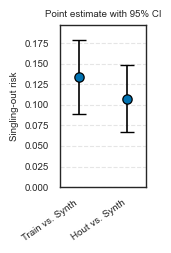

In [38]:
plot_point_estimate_ci(df_plot)

## UpSet-Plot (Explorative Analyse der wichtigsten Features/Kombis)

In [183]:
df_features = pd.read_csv(cfg.results_dir / f"feature_comb_train-synth_20250515_090138.csv", sep=";", decimal=",")
df_features_holdout_synthetic = pd.read_csv(cfg.results_dir / f"feature_comb_holdout-synth_20250515_090138.csv", sep=";", decimal=",")

In [40]:
# FutureWarnings in UpSetPlot unterdrücken (betrifft inplace-Operationen und Downcasting - kein Einfluss auf aktuelle Analyse)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="upsetplot\\.data"
)
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    module="upsetplot\\.plotting"
)

### Train vs. Synth

Abbildung gespeichert unter: figures\Singling-Out_combs_train-synth_20250601_121038.tiff


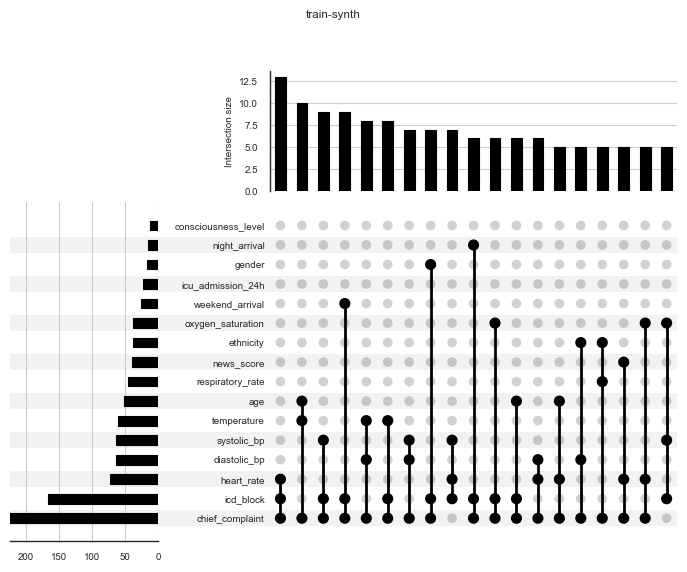

In [188]:
plot_feature_combinations_upset(df_features, show_n_bars=15, title='train-synth')

### Holdout vs. Synth

Abbildung gespeichert unter: figures\Singling-Out_combs_holdout-synth_20250601_121038.tiff


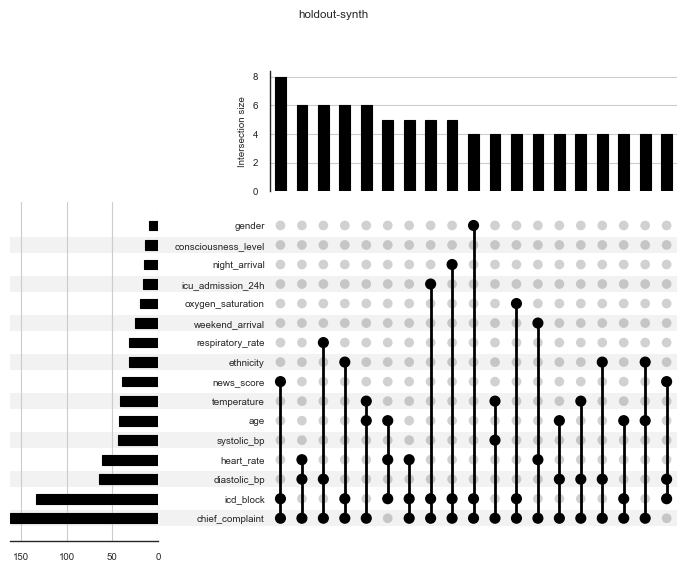

In [189]:
plot_feature_combinations_upset(df_features_holdout_synthetic, show_n_bars=15, title='holdout-synth')